In [1]:
# Step 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.constants import c as speed_of_light
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

In [42]:
with open('FLiTsData100.pkl', 'rb') as f:
    df = pickle.load(f)

In [43]:
data = []
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)

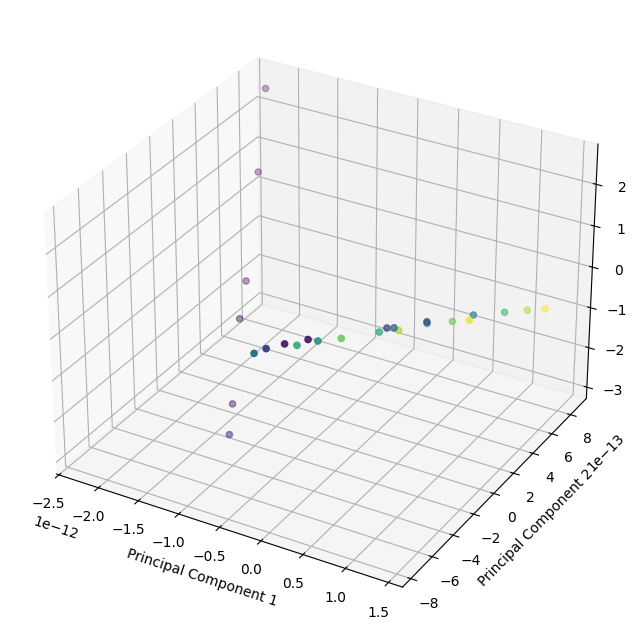

In [44]:
target_column = 'NH3'
X = df_FLiTs_flux.drop(columns=[target_column])
y = df_FLiTs_flux[target_column]
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [52]:
from sklearn.svm import SVR
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

# Step 3: Initialize the RandomForestClassifier
rf = RandomForestRegressor(n_estimators=100)
svm_regressor = SVR(kernel='rbf', C=100, epsilon=0.1)

svm_regressor.fit(X_train, Y_train)

Y_pred_regressor = svm_regressor.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred_regressor)
r2 = r2_score(Y_test, Y_pred_regressor)
print(f'RMSE: {np.sqrt(mse)}')
print(f'R-squared: {r2}')

RMSE: 2.2093502853409463e-15
R-squared: -0.08444823140193014


In [7]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict and evaluate the model
y_pred = best_rf.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print(f'Optimized R-squared: {r2}')

Optimized R-squared: -0.026684963647428894


In [41]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.0001, 0.1, 0.2],
    'kernel': ['linear', 'rbf', 'poly']
}
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Perform grid search with cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=10)
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_svr = grid_search.best_estimator_

# Predict and evaluate the optimized model
Y_pred_best = best_svr.predict(X_test)
print(f'Optimized R-squared: {r2_score(Y_test, Y_pred_best)}')

Optimized R-squared: -0.028822950078707166
